In [3]:
import cv2
import os
pjoin = os.path.join
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
fish_im = []
for fn in sorted([fn for fn in os.listdir('./data') if fn.startswith('fish')]):
    fish_im.append(cv2.imread(pjoin('data',fn), cv2.IMREAD_UNCHANGED))
    assert fish_im[-1].shape[2] == 4, 'No alpha channel'
    #cv2.imwrite(fn, cv2.resize(fish_im[-1],(64,64)))
    
bg_im = []
for fn in sorted([fn for fn in os.listdir('./data') if fn.startswith('bg')]):
    bg_im.append(cv2.imread(pjoin('data',fn)))

(74.0, 217.0) 73.5391052434


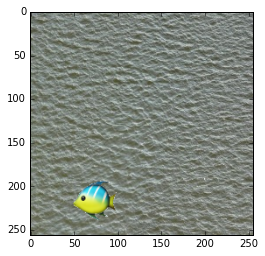

In [3]:
def random_im():
    bg_i = np.random.randint(0, high=len(bg_im), size=1)[0]
    fsh_i = np.random.randint(0, high=len(fish_im), size=1)[0]
    bg = np.copy(bg_im[bg_i])
    fsh = np.copy(fish_im[fsh_i])
    fsh[:,:,3] /= 255
    scale = np.random.rand(1)[0] * 1.5 + 0.25
    fsh = cv2.resize(fsh, (int(scale*fsh.shape[0]), int(scale*fsh.shape[1])))
    y0=np.random.randint(0, bg.shape[0]-fsh.shape[0], 1)[0]
    x0=np.random.randint(0, bg.shape[1]-fsh.shape[1], 1)[0]
    bg[y0:y0+fsh.shape[0], x0:x0+fsh.shape[1], :] = fsh[:,:,:3]*fsh[:,:,3,np.newaxis] + bg[y0:y0+fsh.shape[0], x0:x0+fsh.shape[1], :]*(1-fsh[:,:,3,np.newaxis])
    center = x0+fsh.shape[1]*.5, y0+fsh.shape[0]*.5
    length = np.linalg.norm(fsh.shape[:2])
    return bg, center, length
    
im, center, length = random_im()
print center, length
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

In [4]:
# dx = anchor_x - pred_x
# dy = anchor_y - pred_y
# dl = anchor_l - pred_l

FH, FW = 8, 8
IH, IW = 256, 256

#anchor_lengths = [87, 150, 202, 233, 278]
anchor_lengths = [0.5 * 64, 1.5 * 64]
n_anchors = len(anchor_lengths)

anchor_centers_x_1 = np.linspace(0, IW - 1, FW)
anchor_centers_y_1 = np.linspace(0, IH - 1, FH)
anchor_centers_x, anchor_centers_y = np.meshgrid(anchor_centers_x_1, anchor_centers_y_1)

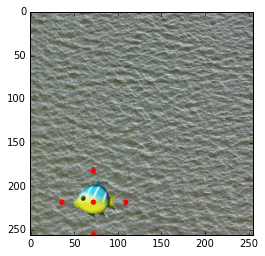

In [5]:
dist = []
for i in range(FH):
    for j in range(FW):
        px = anchor_centers_x[i, j]
        py = anchor_centers_y[i, j]
        d = (px - center[0], py - center[1])
        dist.append(np.linalg.norm(d))
n_top_closest = 5
top_dist_idx = np.argsort(dist)[:n_top_closest]

im_draw = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
for ni in range(n_top_closest):
    idx = top_dist_idx[ni]
    i, j = idx / FW, idx % FW
    #print i, j
    closest_xy = anchor_centers_x[i, j], anchor_centers_y[i, j]
    #print closest_xy
    cv2.circle(im_draw, 
               tuple(np.array(closest_xy, dtype=int)), 
               3, (255,0,0), -1)
plt.imshow(im_draw)

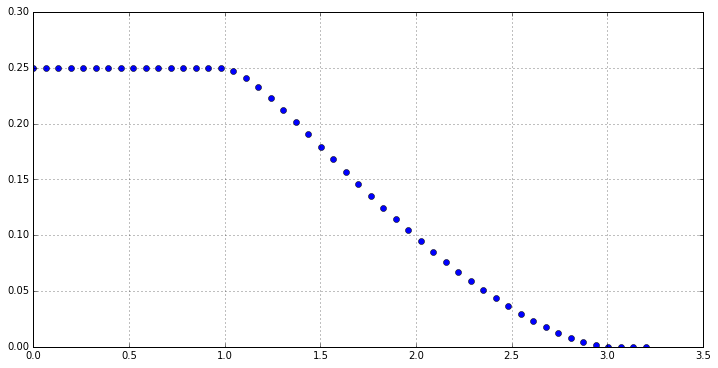

In [34]:
import numpy as np

EPSILON = 1e-12

def c2c_intersect(r1, r2, d):
    assert R >= r
    assert d >= 0
    d = min(d, R + r)
    d = max(d, R - r)
    t1 = r**2 * np.arccos((d**2 + r**2 - R**2)/(2.*d*r))
    t2 = R**2 * np.arccos((d**2 + R**2 - r**2)/(2.*d*R))
    t3 = -0.5 * np.sqrt((-d+r+R)*(d-r+R)*(d+r-R)*(d+r+R))
    A = t1 + t2 + t3
    return A

def c2c_intersect2(x1, y1, x2, y2, r1, r2):
    r = min(r1, r2)
    R = max(r1, r2)
    d_v = (x1 - x2), (y1 - y2)
    d = np.sqrt(d_v[0]**2 + d_v[1]**2)
    return c2c_intersect(r, R, d), r, R, d

def c2c_intersect_many_to_one(many, one):
    r = np.minimum(many[:,2], one[2])
    R = np.maximum(many[:,2], one[2])
    d_orig = np.sqrt(np.square(many[:,0] - one[0]) + np.square(many[:,1] - one[1]))
    d = np.clip(d_orig, R - r, R + r)
    rr = np.square(r)
    RR = np.square(R)
    dd = np.square(d)
    intersection = \
        rr * np.arccos((dd + rr - RR)/(2.*d*r+EPSILON)) + \
        RR * np.arccos((dd + RR - rr)/(2.*d*R+EPSILON)) + \
        -0.5 * np.sqrt((-d + r + R) * (d - r + R) * (d + r - R) * (d + r + R))
    union = np.pi*(rr + RR) - intersection
    iou = intersection / (union + EPSILON)
    return d_orig, intersection, iou

n = 50
r = 1.
R = 2.
eps = 0.2

cx_1 = np.zeros((n,))
cy_1 = np.zeros((n,))
r_1 = np.ones((n,))*r

cx_2 = np.linspace(0, r+R+eps, n)
cy_2 = [0.]*n
r_2 = np.ones((n,))*R

many = np.column_stack([cx_2, cy_2, r_2])
one = np.array([0., 0., r])
d,A,iou = c2c_intersect_many_to_one(many, one)

# A_ = []
# d_ = []
# for i in range(n):
#     Ai, ri, Ri, di = c2c_intersect2(cx_1[i], cy_1[i], cx_2[i], cy_2[i], r_1[i], r_2[i])
#     A_ += [Ai]
#     d_ += [di]
        
plt.figure(figsize=(12,6))
plt.plot(d, iou, 'o')
plt.grid(True)

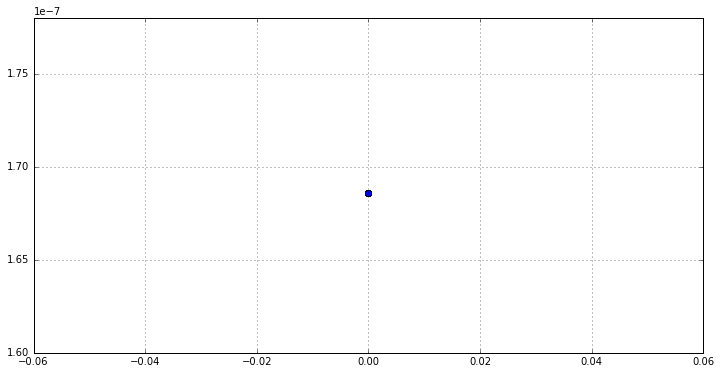

In [6]:
import tensorflow as tf
import numpy as np

N = 50000
x = np.random.randint(0, 12800, N)
y = np.random.randint(0, 7200, N)
cx1 = tf.constant(x, dtype=tf.float32)
cy1 = tf.constant(y, dtype=tf.float32)
#cx2 = tf.constant(x+np.random.randint(80,160,N), dtype=tf.float32)
cx2 = tf.constant(x, dtype=tf.float32)
# cy2 = tf.constant(y+np.random.randint(-10,10,N), dtype=tf.float32)
cy2 = tf.constant(y, dtype=tf.float32)
# r1 = tf.constant(np.random.randint(40,41,N), dtype=tf.float32)
# r2 = tf.constant(np.random.randint(40,41,N), dtype=tf.float32)
r1 = tf.constant(np.ones(N)*40., dtype=tf.float32)
r2 = tf.constant(np.ones(N)*97202., dtype=tf.float32)

class mc:
    EPSILON=1e-16

def _tensor_iou(circle1, circle2):
    eps = 1e-9
    cx1, cy1, r1 = circle1
    cx2, cy2, r2 = circle2

    with tf.variable_scope('intersection'):
        r = tf.minimum(r1, r2)
        R = tf.maximum(r1, r2)
        d_orig = tf.sqrt(tf.square(cx1 - cx2) + tf.square(cy1 - cy2))
        d = tf.clip_by_value(d_orig, R - r, R + r)
        rr = tf.square(r)
        RR = tf.square(R)
        dd = tf.square(d)
        cos1 = tf.clip_by_value((dd + rr - RR)/(2.*d*r + eps), -1., 1.)
        cos2 = tf.clip_by_value((dd + RR - rr)/(2.*d*R + eps), -1., 1.)
        intersection = rr * tf.acos(cos1) + \
                     RR * tf.acos(cos2) + \
                     -0.5 * tf.sqrt((-d + r + R) * (d - r + R) * (d + r - R) * (d + r + R))

    with tf.variable_scope('union'):
        union = np.pi*(tf.square(r1) + tf.square(r2)) - intersection

    return intersection, union, intersection/(union+eps), d_orig

with tf.Session() as sess:
    A, union, iou, d_orig = sess.run([_tensor_iou([cx1, cy1, r1], [cx2, cy2, r2])])[0]
    
    assert not np.nan in iou
    
    plt.figure(figsize=(12,6))
    plt.plot(d_orig, iou, 'o')
    plt.grid(True)
    #print A.eval()
    #print union.eval()